# Compare ICESat-2, CryoSat-2, and Operation Ice Bridge ATM topography
### To do this I will provide the option to subset all datasets to my Alpine-3D domain. I will then create scatter plots of ATM vs. ICESat-2 and ATM vs. CryoSat-2. In this case, I will consider ATM as "ground truth". Furthermore I will plot all three data sets along the transect over which I have been evaluating Alpine-3D.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gdal
import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from scipy import stats

# Retrieve ICESat-2 topography

In [11]:
ic2_path = "/pl/active/nasa_smb/Data/IS2_cycle_1_2_3_DEM_noFilter.nc"
ic2_elevation = xr.open_dataset(ic2_path)
# ic2_elevation = ic2_elevation.rename({'x': 'easting', 'y': 'northing'})
# ic2_elevation = ic2_elevation['Elevation']
ic2_elevation

<xarray.Dataset>
Dimensions:      (x: 6651, y: 6651)
Coordinates:
  * x            (x) float64 -3.325e+06 -3.324e+06 ... 3.324e+06 3.325e+06
  * y            (y) float64 -3.325e+06 -3.324e+06 ... 3.324e+06 3.325e+06
Data variables:
    Elevation    (x, y) float64 ...
    Uncertainty  (x, y) float64 ...
Attributes:
    creation_date:  22-Sep-2020 13:45:11

In [10]:
ic2_elevation.swap_dims({"y": "x"})

ValueError: replacement dimension 'x' is not a 1D variable along the old dimension 'y'

In [5]:
# Save a temporary .nc file
ic2_elevation.to_netcdf(path="/scratch/summit/erke2265/tmp.nc")

# Retrieve CryoSat-2 topography

In [3]:
# load data
cs2_path = "../input/surface-grids/dem.asc"
cs2_z = np.loadtxt(cs2_path, skiprows=6)

# Define corners and easting/northings
x_min = -1557000
x_max = x_min + (198 - 1) * 1000
y_min = -124000
y_max = y_min + (137 - 1) * 1000
X = np.linspace(x_min, x_max, 198)
Y = np.linspace(y_min, y_max, 137)

# Create xarray object
cs2_elevation = xr.DataArray(np.flipud(cs2_z), name="elevation", coords=[Y, X], dims=["northing", "easting"])
cs2_elevation

<xarray.DataArray 'elevation' (northing: 137, easting: 198)>
array([[ 721.19586182,  721.77581787,  723.38586426, ..., 1514.36730957,
        1514.75305176, 1517.43054199],
       [ 723.38586426,  723.51800537,  724.01037598, ..., 1513.73339844,
        1514.43139648, 1518.17089844],
       [ 723.66937256,  723.74212646,  724.32714844, ..., 1513.28955078,
        1514.70129395, 1518.69506836],
       ...,
       [1086.04492188, 1088.89318848, 1091.04492188, ..., 1435.85095215,
        1443.08618164, 1445.69677734],
       [1092.08825684, 1094.52783203, 1095.66162109, ..., 1429.42077637,
        1435.85095215, 1437.74487305],
       [1098.40515137, 1099.00024414, 1099.00793457, ..., 1422.37365723,
        1429.42077637, 1432.10107422]])
Coordinates:
  * northing  (northing) float64 -1.24e+05 -1.23e+05 ... 1.1e+04 1.2e+04
  * easting   (easting) float64 -1.557e+06 -1.556e+06 ... -1.361e+06 -1.36e+06

# Retrieve OIB ATM topography

In [4]:
# Load ATM data
atm_path = "/pl/active/nasa_smb/Data/ATM_20161109.txt"
atm_lat, atm_lon, atm_z = np.loadtxt(atm_path, delimiter=",", skiprows=1, usecols=(1,2,3), unpack=True)

# Convert to xarray object
atm_elevation = xr.DataArray(atm_z, name="elevation", coords=[atm_lat], dims=["lat"])
atm_elevation = atm_elevation.assign_coords(lon=("lat", atm_lon))
atm_elevation

<xarray.DataArray 'elevation' (lat: 250015)>
array([198.319 , 190.2892, 186.4853, ..., -30.8759, -30.7447, -30.865 ])
Coordinates:
  * lat      (lat) float64 -73.07 -73.07 -73.07 -73.07 ... -74.46 -74.46 -74.46
    lon      (lat) float64 270.2 270.2 270.2 270.2 ... 254.7 254.7 254.7 254.7

# Convert all coordinates to EPSG 3031

In [5]:
# Source and target EPSG
src = osr.SpatialReference()
tgt = osr.SpatialReference()
src.ImportFromEPSG(4326) # WGS-84
tgt.ImportFromEPSG(3031) # South Polar Stereo

# Define transformation
transform = osr.CoordinateTransformation(src, tgt)

# Initialize arrays
atm_X = np.zeros(len(atm_elevation)); atm_X[:] = np.nan
atm_Y = np.zeros(len(atm_elevation)); atm_Y[:] = np.nan
atm_lat = atm_elevation['lat'].values
atm_lon = atm_elevation['lon'].values

# Perform transformation
for j in range(0, len(atm_X)):
    coords = transform.TransformPoint(atm_lat[j], atm_lon[j]) # Lat, Lon
    atm_X[j], atm_Y[j] = coords[0:2]

# Add easting and northings to dataset 
atm_elevation = atm_elevation.assign_coords(easting=("lat", atm_X))
atm_elevation = atm_elevation.assign_coords(northing=("lat", atm_Y))
atm_elevation

<xarray.DataArray 'elevation' (lat: 250015)>
array([198.319 , 190.2892, 186.4853, ..., -30.8759, -30.7447, -30.865 ])
Coordinates:
  * lat       (lat) float64 -73.07 -73.07 -73.07 -73.07 ... -74.46 -74.46 -74.46
    lon       (lat) float64 270.2 270.2 270.2 270.2 ... 254.7 254.7 254.7 254.7
    easting   (lat) float64 -1.852e+06 -1.852e+06 ... -1.638e+06 -1.638e+06
    northing  (lat) float64 5.265e+03 5.415e+03 ... -4.478e+05 -4.479e+05

# Subset all datasets to Alpine-3D domain

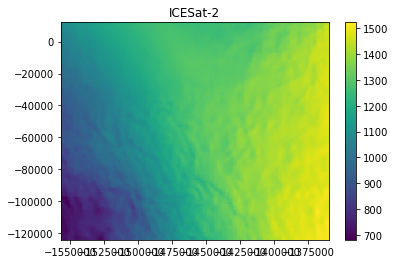

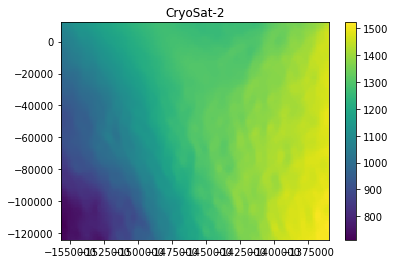

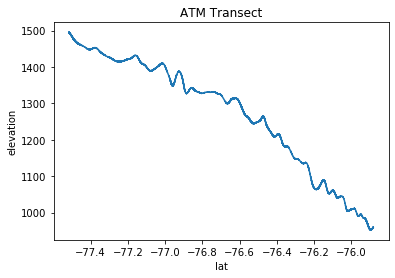

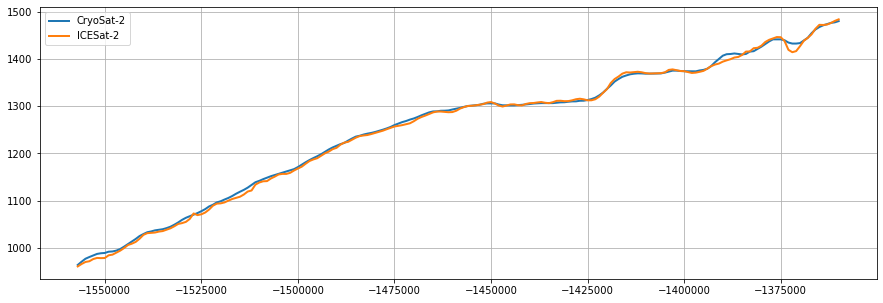

In [6]:
# Write a function that trims xarray data array object
def trim_da(da, x_min, x_max, y_min, y_max):
    da = da.where(da.easting >= x_min, drop=True)
    da = da.where(da.easting <= x_max, drop=True)
    da = da.where(da.northing >= y_min, drop=True)
    da = da.where(da.northing <= y_max, drop=True)
    return da

# Now trim the data sets
ic2_elevation = trim_da(ic2_elevation, x_min, x_max, y_min, y_max)
cs2_elevation = trim_da(cs2_elevation, x_min, x_max, y_min, y_max)
atm_elevation = trim_da(atm_elevation, x_min, x_max, y_min, y_max)

# Plot all datasets
plt.figure()
ic2_z = np.transpose(ic2_elevation.values)
plt.pcolor(ic2_elevation['easting'], ic2_elevation['northing'], ic2_z)
plt.colorbar()
plt.title("ICESat-2")

plt.figure()
plt.pcolor(cs2_elevation['easting'], cs2_elevation['northing'], cs2_elevation)
plt.colorbar()
plt.title("CryoSat-2")

plt.figure()
atm_elevation.plot()
plt.title("ATM Transect")

plt.figure(figsize=(15, 5))
plt.plot(cs2_elevation['easting'], cs2_elevation[100, :], linewidth=2, label="CryoSat-2")
plt.plot(ic2_elevation['easting'], ic2_z[100, :], linewidth=2, label="ICESat-2")
plt.grid()
plt.legend()

# Retrieve closest ICESat-2 and CryoSat-2 elevation at each ATM point

In [7]:
# Define target eastings and northings (from ATM observations)
tgt_X = xr.DataArray(atm_elevation['easting'].values, dims="points")
tgt_Y = xr.DataArray(atm_elevation['northing'].values, dims="points")

# Retrieve target data
tgt_ic2_z = ic2_elevation.sel(easting=tgt_X, northing=tgt_Y, method="nearest")
tgt_cs2_z = cs2_elevation.sel(easting=tgt_X, northing=tgt_Y, method="nearest")

# Scatter plots of ATM vs. ICESat-2/CryoSat-2

ICESat-2
    R^2 = 0.9994298829072686
    RMSE = 3.684202105369762

CryoSat-2
    R^2 = 0.9976721826490205
    RMSE = 9.153003290517443


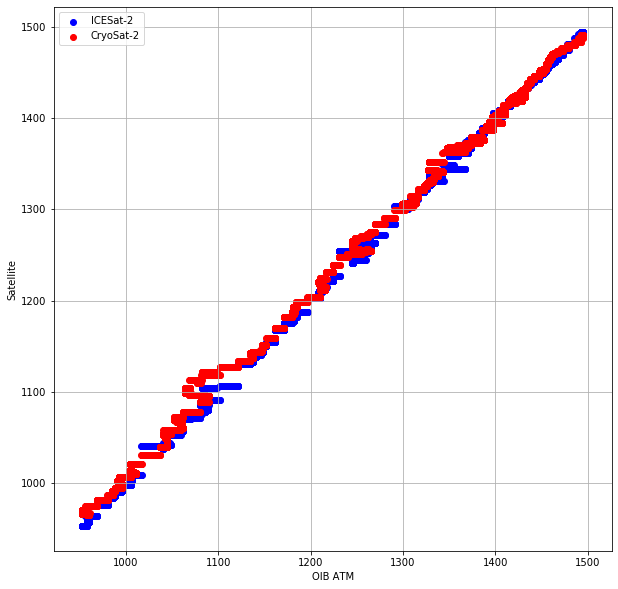

In [8]:
# Calculate root mean squared error
def calc_rmse(x, y):
    squared_diff = (y - x) ** 2
    mean_squared_diff = np.nanmean(squared_diff)
    rmse = np.sqrt(mean_squared_diff)
    return rmse


plt.figure(figsize=(10, 10))
plt.scatter(atm_elevation, tgt_ic2_z, c='b', label="ICESat-2")
plt.scatter(atm_elevation, tgt_cs2_z, c='r', label="CryoSat-2")
plt.grid()
plt.xlabel("OIB ATM")
plt.ylabel("Satellite")
plt.legend()

# Stats
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(atm_elevation, tgt_ic2_z)
rmse = calc_rmse(atm_elevation.values, tgt_ic2_z.values)
print("ICESat-2")
print("    R^2 = " + str(r_value**2))
print("    RMSE = " + str(rmse))
print()

slope, intercept, r_value, p_value, std_err = \
    stats.linregress(atm_elevation, tgt_cs2_z)
rmse = calc_rmse(atm_elevation.values, tgt_cs2_z.values)
print("CryoSat-2")
print("    R^2 = " + str(r_value**2))
print("    RMSE = " + str(rmse))


# Transect plot of ATM, ICESat-2, and CryoSat-2

(-50, 50)

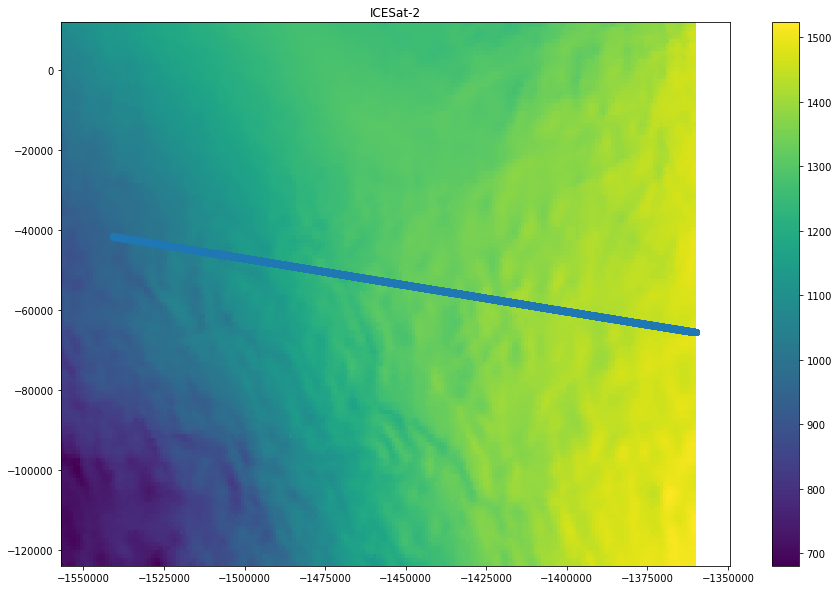

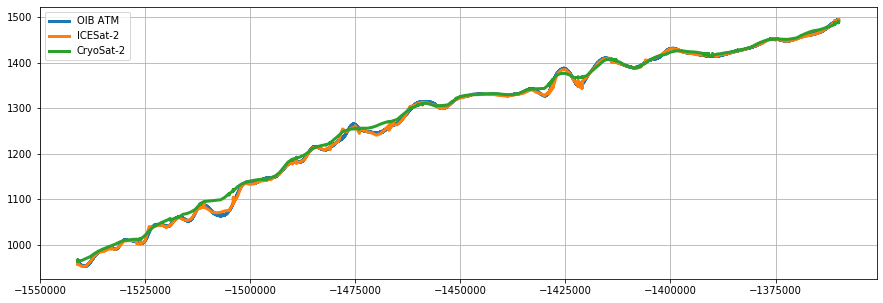

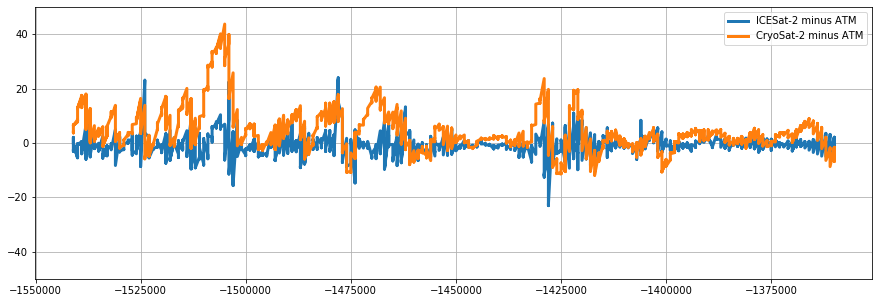

In [9]:
# Plot map
plt.figure(figsize=(15, 10))
ic2_z = np.transpose(ic2_elevation.values)
plt.pcolor(ic2_elevation['easting'], ic2_elevation['northing'], ic2_z)
plt.colorbar()
plt.title("ICESat-2")
plt.scatter(atm_elevation['easting'], atm_elevation['northing'])

# Plot Transect
plt.figure(figsize=(15, 5))
plt.plot(atm_elevation['easting'], atm_elevation, linewidth=3, label='OIB ATM')
plt.plot(tgt_ic2_z['easting'], tgt_ic2_z, linewidth=3, label='ICESat-2')
plt.plot(tgt_cs2_z['easting'], tgt_cs2_z, linewidth=3, label='CryoSat-2')
plt.legend()
plt.grid()

# Plot differences
plt.figure(figsize=(15, 5))
plt.plot(tgt_ic2_z['easting'], tgt_ic2_z.values - atm_elevation.values, linewidth=3, label='ICESat-2 minus ATM')
plt.plot(tgt_cs2_z['easting'], tgt_cs2_z.values - atm_elevation.values, linewidth=3, label='CryoSat-2 minus ATM')
plt.legend()
plt.grid()
plt.ylim([-50, 50])

# Plot ICESat-2 minus CryoSat-2 map

Text(0.5, 1.0, 'ICESat-2 minus CryoSat-2')

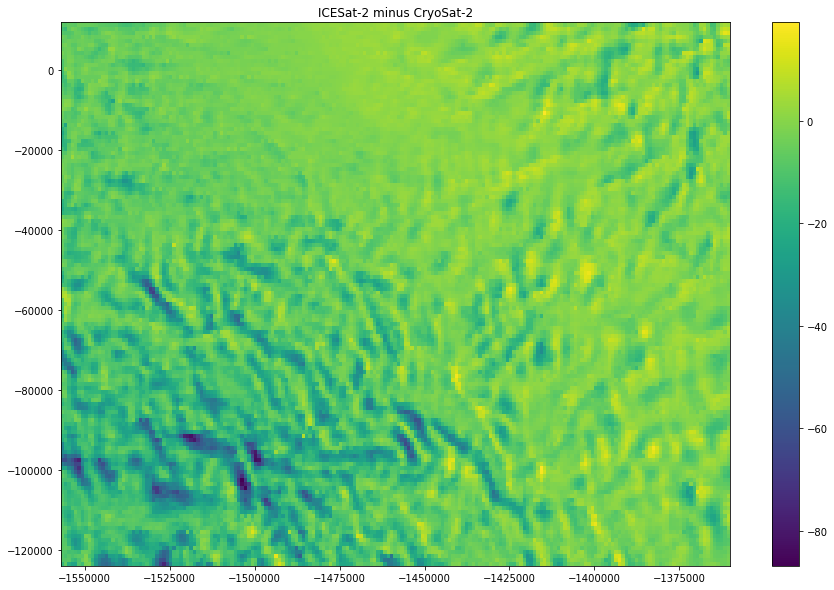

In [18]:
map_diff = np.transpose(ic2_elevation.values) - cs2_elevation.values

# Plot map
plt.figure(figsize=(15, 10))
plt.pcolor(ic2_elevation['easting'].values, ic2_elevation['northing'].values, map_diff)
plt.colorbar()
plt.title("ICESat-2 minus CryoSat-2")